In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

# Read in Audio Files

In [34]:
filename = '108-42.aiff'

# Load in via `librosa`
samples, sr = librosa.load(filename, mono=False)
print(f'y: {y[:3]}')
print(f'Sample rate (sr): {sr}')

y: [[-5.9577981e-03 -1.0904573e-02 -1.2646006e-02 ...  1.1178328e-03
   1.2365828e-03  0.0000000e+00]
 [-5.2088755e-03 -2.8845789e-03  3.1288061e-04 ... -1.0879453e-02
  -2.2151597e-02  0.0000000e+00]
 [ 2.0839400e-06 -1.8307594e-05 -5.4703749e-05 ...  1.9840855e-04
   2.4076334e-04  0.0000000e+00]]
Sample rate (sr): 22050


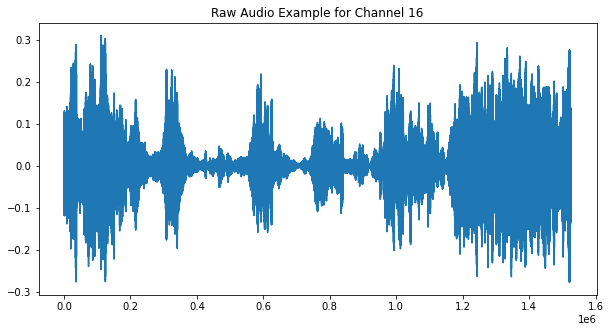

In [35]:
channel = 16
pd.Series(samples[channel - 1]).plot(figsize=(10,5), title=f'Raw Audio Example for Channel {channel}')
plt.show()

# Get Pitch

## Method 1. Use STFT (Short Time Fourier Transform) to Analyze Freq

In [36]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [117]:
# VARIABLES
nperseg = 4500

channel = 2
t_i = 0
t_f = None
if t_f == None:
    t_f = sr * channel

    
# Setup
fs = sr
target_range = slice(t_i * fs ,t_f * fs)
x = samples[channel - 1][target_range]

# Run STFT
f, t, Zxx = signal.stft(x, fs, nperseg=nperseg)

print(np.abs(Zxx).min(), np.abs(Zxx).max(), np.abs(Zxx).mean())
print(t[:5])

3.846169e-14 0.03019345 8.1368526e-05
[0.         0.10204082 0.20408163 0.30612245 0.40816327]


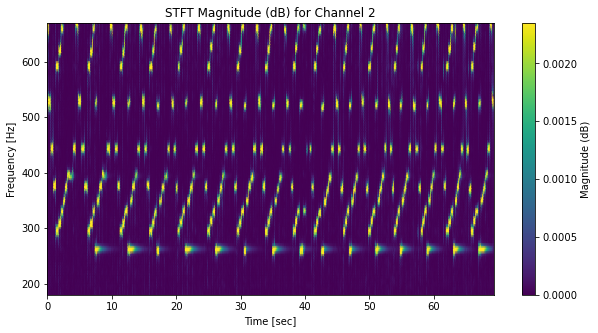

In [118]:
# VARIABLES
vmin = 0
vmax = np.abs(Zxx.max()) / 10
freq_min = 180 # in Hz, (196Hz is G3)
freq_max = 670 # in Hz, (659.3Hz is E5)

# Plot
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, np.abs(Zxx), vmin=vmin, vmax=vmax, shading='gouraud')
plt.ylim([freq_min,freq_max])
plt.title(f'STFT Magnitude (dB) for Channel {channel}')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Magnitude (dB)')
plt.savefig(f'STFT Magnitude (dB) for Channel {channel}.png', dpi=400)

## Method 2. Estimate Fundament Pitch using pYIN algorithm

In [133]:
import librosa

channel = 3
sample = samples[channel - 1]

fmin = 180 # in Hz
fmax = 670

# pYIN algorithm
f0, voiced_flag, voiced_probs = librosa.pyin(sample, fmin=fmin, fmax=fmax)

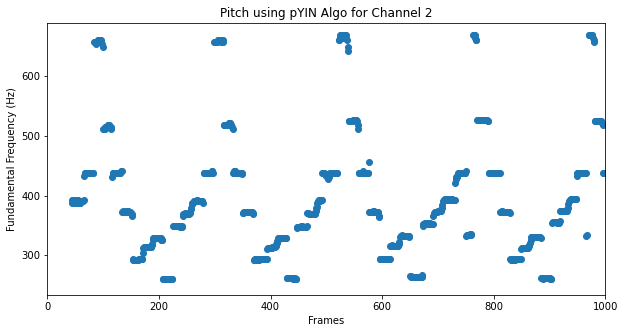

In [137]:
plt.figure(figsize = (10,5))
plt.scatter(range(len(f0)), f0)
plt.xlim([0,1000])
plt.xlabel('Frames')
plt.ylabel('Fundamental Frequency (Hz)')
plt.title(f'Pitch using pYIN Algo for Channel {channel - 1}')
plt.show()

In [121]:
voiced_probs.mean()

0.8127268857496411

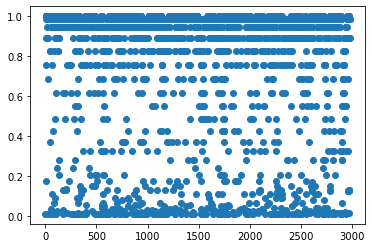

In [122]:
plt.scatter(range(len(voiced_probs)), voiced_probs)

# Determine Period of Play

# Turn this into modular code

In [79]:
from typing import List, Dict

def find_pitch(sample: np.array, sr: int, nperseg: int = 20000) -> List[Dict[str, np.array]]:
    '''
    Find pitch from waveform
    Arguments come from
    samples, sr = librosa.load(filename, mono=False)
    
    Args:
    * samples (np.array) - waveforms for single channel
    * sr (int) - sample rate
    
    Returns:
    * stft_data - 
    '''
    
    stft_data = []
    for channel in range(len(samples)):  
        # Run STFT
        x = samples[channel - 1]
        f, t, Zxx = signal.stft(x, sr, nperseg=nperseg)
        
        result_for_channel = dict(f=f, t=t, Zxx=Zxx)
        stft_data.append(result_for_channel)
    
    return stft_data    
    

def plot_STFT(f, t, Zxx):
    # VARIABLES
    vmin = 0
    vmax = np.abs(Zxx.max()) / 10
    freq_min = 180 # in Hz, (196Hz is G3)
    freq_max = 670 # in Hz, (659.3Hz is E5)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=vmin, vmax=vmax, shading='gouraud')
    plt.ylim([freq_min,freq_max])
    plt.title(f'STFT Magnitude (dB) for Channel {channel}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar().set_label('Magnitude (dB)')
    plt.savefig(f'STFT Magnitude (dB) for Channel {channel}.png', dpi=400)

In [80]:
stft_data = find_pitch(samples, sr)

In [81]:
stft_data[0]['Zxx']

array([[-2.6420959e-05+0.00000000e+00j,  2.9425223e-06+0.00000000e+00j,
        -1.7562694e-06+0.00000000e+00j, ...,
         1.2187851e-06+0.00000000e+00j, -5.8316000e-06+0.00000000e+00j,
        -1.1167712e-05+0.00000000e+00j],
       [ 2.1835933e-05-5.84599456e-06j, -8.2135066e-06-1.70622411e-06j,
         2.4892202e-06-2.11548218e-06j, ...,
        -2.1937660e-06-4.87907573e-06j, -2.0240302e-06-7.78795948e-06j,
         3.6335805e-06+1.02720605e-05j],
       [-1.3278586e-05+1.42394185e-06j,  8.0419295e-06+1.25786300e-05j,
         8.4906623e-07+1.11215013e-05j, ...,
        -3.4715549e-06+1.10827432e-05j,  2.9934590e-06+2.14654483e-06j,
         7.8092280e-06-7.09060032e-06j],
       ...,
       [ 5.8731666e-07+9.91096316e-10j,  2.1323616e-11+9.64666888e-11j,
        -9.3087177e-11+3.29833383e-11j, ...,
         2.8762333e-11+3.16568785e-11j,  1.1047707e-06+9.08139612e-07j,
         2.2290935e-06+1.83216423e-06j],
       [-5.8729353e-07-4.74308315e-10j, -1.3869147e-11-5.75040501e-1